In [1]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
import matplotlib.patches as patches
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random
from importlib import reload
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

import surprise as sup

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

# load population scores

In [2]:
resolution = 1000000
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/global_core_score/population_mESC_{resolution}_scores.csv"
scores = pd.read_csv(fpath)
print(f"{scores.shape=}")

scores.head()

scores.shape=(2431, 36)


,bin_name,bin_index,bin_start,bin_end,bin,chrom,chrom_bin,degree,genes,n_genes,...,ce_betweenness_centrality,ce_pagerank,hge_singular_vector_1,hge_logexp_unweighted,hge_logexp_degree_weighted,hge_logexp_RNA_weighted,hge_logexp_ATAC_weighted,global_singular_vector_1,global_hge_logexp_unweighted,global_hge_logexp_RNA_weighted
0,chr1:3,2235,3000000,4000000,3,1,3,2953,Gm37363;Gm37381;Gm7341;Gm38148;Gm37180;Gm19938...,15,...,0.671480,0.117995,0.000000,0.148099,0.000000,0.174370,0.222380,0.330855,0.501567,0.167764
1,chr1:4,964,4000000,5000000,4,1,4,3331,Gm7369;A930006A01Rik;Gm37381;Gm38076;Mrpl15;Gm...,22,...,0.267148,0.372869,0.103845,0.239187,0.281148,0.468270,0.560302,0.412235,0.609261,0.369136
2,chr1:5,1823,5000000,6000000,5,1,5,3341,Atp6v1h;Gm17101;Gm16041;Rgs20;Gm36965;Gm38264;...,12,...,0.109507,0.224249,0.057865,0.647027,0.201096,0.243125,0.405148,0.425601,0.528269,0.216383
3,chr1:6,1288,6000000,7000000,6,1,6,3422,St18;Gm7449;Gm19214;Gm37108;Gm2147;Gm19026;473...,10,...,0.009627,0.534940,0.172229,0.760979,0.401754,0.250762,0.521777,0.448264,0.492633,0.258762
4,chr1:7,144,7000000,8000000,7,1,7,3289,Gm23274;Gm5694;Rps2-ps2;Gm37225;Gm37489;Gm2690...,18,...,0.252708,0.099600,0.053319,0.000000,0.160235,0.190846,0.204818,0.414267,0.510526,0.204855


# load population gene mapping

In [3]:
""" LOAD the TF list """
fpath = "/nfs/turbo/umms-indikar/shared/projects/twin_cell/data/b_matrix/SCENIC/scenic/tf_lists/allTFs_mm.txt"
tf_list = [x.strip() for x in open(fpath)]

""" LOAD the genes """
fpath = f"/scratch/indikar_root/indikar1/shared_data/higher_order/lightweight/population_mESC_{resolution}_gdf.parquet"
df = pd.read_parquet(fpath)
df['is_tf'] = df['gene_name'].isin(tf_list)

""" MERGE the core scores """
merge_columns = [
    'bin_name',
    'ATACSeq_1',
    'CTCF',
    'H3K27ac', 
    'H3K27me3',
    'RNA_5',
    'global_hge_logexp_RNA_weighted'
]

df = pd.merge(
    df, scores[merge_columns].fillna(0.0), how="left",
)

""" DEFINE the core """
order_threshold = 3
score_column = 'global_hge_logexp_RNA_weighted'
core_threshold_quantile = 0.75
threshold = np.quantile(df[score_column], core_threshold_quantile)
df['is_core'] = df[score_column] > threshold

"""ADD the gene order """
df['order'] = df.groupby('read_name')['gene_name'].transform('nunique')

print(f"{df.shape=}")
df.head()

df.shape=(4939267, 13)


,gene_name,gene_biotype,read_name,bin_name,is_tf,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_5,global_hge_logexp_RNA_weighted,is_core,order
0,Ulk4,protein_coding,3891ee6d-53d1-4ee0-ba2f-3d22291d4493,chr9:121,False,0.826484,1.149226,1.349552,0.866066,0.573875,0.254849,False,2
1,Smarca2,protein_coding,66953ddf-e76d-4cdf-aaf8-be028a2d7b04,chr19:26,False,0.497386,0.547185,0.336787,0.839273,0.141617,0.157878,False,11
2,Dlgap3,protein_coding,ad5b2240-893f-4ed0-a157-c2be66d8d754,chr4:127,False,0.754788,1.027046,1.577616,0.839461,0.906364,0.491722,False,5
3,Gm56531,lncRNA,3f354c45-5e48-4f6d-8c7e-05369432b344,chr12:8,False,0.690311,0.851758,0.774613,0.833768,0.617768,0.310082,False,1
4,Twsg1,protein_coding,d4626feb-16a2-4aac-8145-53e89b60bf7c,chr17:66,False,0.767515,0.921479,1.337415,0.571748,0.508463,0.289030,False,1


# Develop baseline models (core score as rating)

In [4]:
order_threshold = 2
n_ratings = 3

""" FILTER low order reads """
H = df.copy()
H = H[H['order'] >= order_threshold]
H = H.sort_values(by='read_name')

"""DEFINE the rating weight based on the core score """
H['core_score'] = H['global_hge_logexp_RNA_weighted'].fillna(0.0)
H['rating'] = pd.cut(H['core_score'], n_ratings, labels=list(range(1, n_ratings+1)))

"""RENAME columns """
H = H.rename(columns={
    'read_name' : 'userID',
    'gene_name' : 'itemID',
})

print(H['rating'].value_counts())
print()
print(H['rating'].value_counts(normalize=True))

H.head()

rating
1    2738157
2    1275394
3      45806
Name: count, dtype: int64

rating
1    0.674530
2    0.314186
3    0.011284
Name: proportion, dtype: float64


,itemID,gene_biotype,userID,bin_name,is_tf,ATACSeq_1,CTCF,H3K27ac,H3K27me3,RNA_5,global_hge_logexp_RNA_weighted,is_core,order,core_score,rating
1566802,Zfpm2,protein_coding,00000b61-7794-4b29-9f89-2b74e7bbce3e,chr15:40,False,0.508949,0.476147,0.311511,0.726722,0.040169,0.103880,False,3,0.103880,1
3729957,Dhx9,protein_coding,00000b61-7794-4b29-9f89-2b74e7bbce3e,chr1:153,False,0.824483,0.908631,1.479928,0.530789,1.799486,0.584635,False,3,0.584635,2
3755967,Bmerb1,protein_coding,00000b61-7794-4b29-9f89-2b74e7bbce3e,chr16:13,False,0.788200,0.850514,1.477219,0.333121,0.433337,0.280054,False,3,0.280054,1
4542482,Lhfpl4,protein_coding,00001034-f0ab-41c2-885a-da17c2b836ae,chr6:113,False,0.908726,1.061913,1.630163,0.557697,0.703616,0.353439,False,2,0.353439,2
3129040,Grm1,protein_coding,00001034-f0ab-41c2-885a-da17c2b836ae,chr10:10,False,0.480704,0.426000,0.223598,0.691076,0.053160,0.096215,False,2,0.096215,1


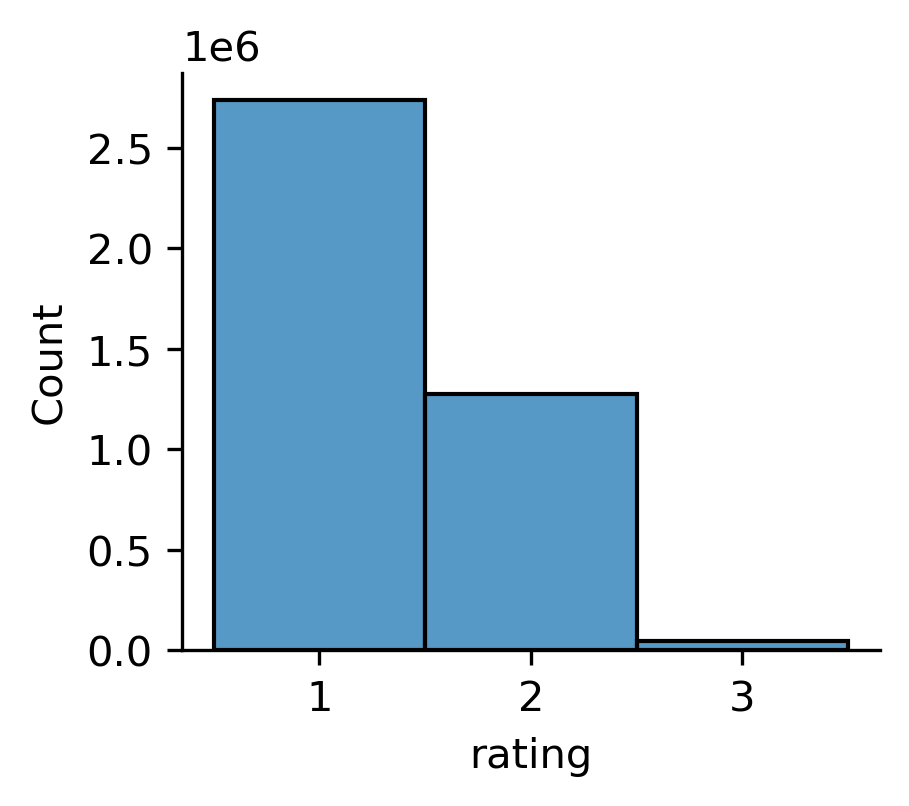

In [5]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 3, 2.5

sns.histplot(
    data=H, 
    x='rating',
    discrete=True,
)
sns.despine()

# Baseline model


------- baseline -------
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...

------- SVD -------

------- SVD++ -------


,test_rmse,test_mae,fit_time,test_time,fold,algorithm
0,0.322032,0.256427,0.687200,0.071966,1,baseline
1,0.321494,0.254665,0.789473,0.073800,2,baseline
2,0.320027,0.254810,0.837797,0.344778,3,baseline
3,0.321359,0.256185,0.808438,0.073237,4,baseline
4,0.323256,0.257800,0.875282,0.074228,5,baseline


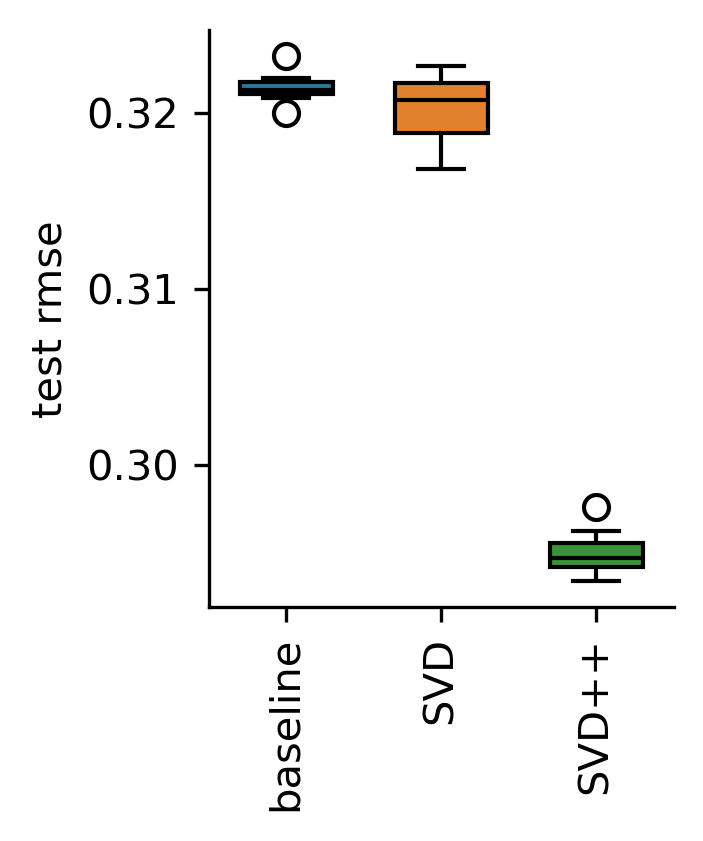

In [6]:
fold = 7
sample_size = 50000

""" SAMPLE hyperedges """
sampled_reads = np.random.choice(H['userID'].unique(), sample_size, replace=False)
sampled_reads[:2]
sample_H = H[H['userID'].isin(sampled_reads)]

""" LOAD data """
reader = sup.Reader(rating_scale=(1, n_ratings+1))
data = sup.Dataset.load_from_df(sample_H[["userID", "itemID", "rating"]], reader)

algorithms = {
    "baseline" : sup.BaselineOnly(),
    "SVD" : sup.SVD(),
    "SVD++" : sup.SVDpp(),
    "NMF" : sup.NMF(),
}

""" TRAIN some models data """
results = []
for label, algo in algorithms.items():
    # Run 5-fold cross-validation and print results
    print(f"\n------- {label} -------")
    res = sup.model_selection.cross_validate(
        algo, 
        data,
        measures=["RMSE", "MAE"], 
        cv=fold,
        verbose=False,
    )
    res = pd.DataFrame(res)
    res['fold'] = list(range(1, fold+1))
    res['algorithm'] = label
    results.append(res)

results = pd.concat(results)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2.5

sns.boxplot(
    data=results,
    x='algorithm',
    y='test_rmse',
    hue='algorithm',
    linecolor='k',
    width=0.6,
)

plt.ylabel("test rmse")
plt.xlabel("")
plt.gca().tick_params(axis='x', rotation=90)
sns.despine()

results.head()

# hyperparameter tuning

In [8]:
fold = 5
sample_size = 10000
algo = sup.SVDpp

""" SAMPLE hyperedges """
sampled_reads = np.random.choice(H['userID'].unique(), sample_size, replace=False)
sampled_reads[:2]
sample_H = H[H['userID'].isin(sampled_reads)]

""" LOAD data """
reader = sup.Reader(rating_scale=(1, n_ratings+1))
data = sup.Dataset.load_from_df(sample_H[["userID", "itemID", "rating"]], reader)


param_grid = {
    "n_factors" : [1, 5, 10, 25],
    "n_epochs": [10, 20],
    "lr_all": [0.002, 0.005],
    "reg_all": [0.2, 0.4, 0.6, 0.8],
}

gs = sup.model_selection.GridSearchCV(
    algo, 
    param_grid, 
    measures=["rmse", "mae"], 
    cv=fold,
)

gs.fit(data)

# best RMSE score
print(gs.best_score["rmse"])

# combination of parameters that gave the best RMSE score
print(gs.best_params["rmse"])

0.4160318772279636
{'n_factors': 1, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


# Train and evaluate

In [ ]:
algo = gs.best_estimator["rmse"]

In [ ]:
break

In [7]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

# what about TF-IDF

In [ ]:
corpus = H.groupby('userID')['itemID'].apply(lambda x: " ".join(list(x)))
corpus.head().to_list()

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus.to_list())
print(f"{X.shape=}")

# Get the indices of non-zero elements
rows, cols = X.nonzero()
gene_names = vectorizer.get_feature_names_out()
read_names = H['userID'].unique()

# Create a DataFrame directly from the non-zero values and their indices
pdf = pd.DataFrame({
    'itemID': gene_names[cols],
    'weight': X.data,
    'userID': read_names[rows]
})

pdf['rating'] = pd.cut(pdf['weight'], n_ratings, labels=list(range(1, n_ratings+1)))

pdf.head()

In [ ]:
""" SAMPLE hyperedges """
sampled_reads = np.random.choice(pdf['userID'].unique(), sample_size, replace=False)
sampled_reads[:2]
sample_H = pdf[pdf['userID'].isin(sampled_reads)]

""" LOAD data """
reader = sup.Reader(rating_scale=(1, n_ratings+1))
data = sup.Dataset.load_from_df(sample_H[["userID", "itemID", "rating"]], reader)

algorithms = {
    "baseline" : sup.BaselineOnly(),
    "SVD" : sup.SVD(),
    "SVD++" : sup.SVDpp(),
}

""" TRAIN some models data """
results = []
for label, algo in algorithms.items():
    # Run 5-fold cross-validation and print results
    print(f"\n------- {label} -------")
    res = sup.model_selection.cross_validate(
        algo, 
        data,
        measures=["RMSE", "MAE"], 
        cv=fold,
        verbose=False,
    )
    res = pd.DataFrame(res)
    res['fold'] = list(range(1, fold+1))
    res['algorithm'] = label
    results.append(res)

results = pd.concat(results)

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 2, 2.5

sns.boxplot(
    data=results,
    x='algorithm',
    y='test_rmse',
    hue='algorithm',
    linecolor='k',
    width=0.6,
)

plt.ylabel("test rmse")
plt.xlabel("")
plt.gca().tick_params(axis='x', rotation=90)
sns.despine()

results.head()